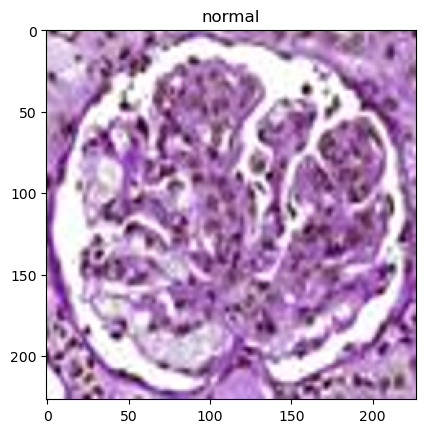

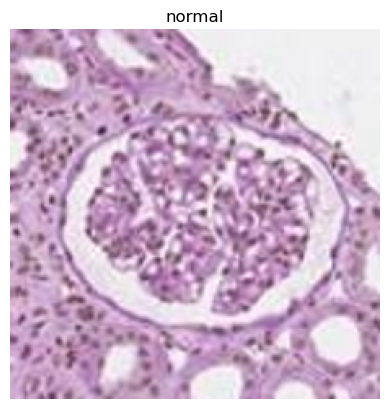

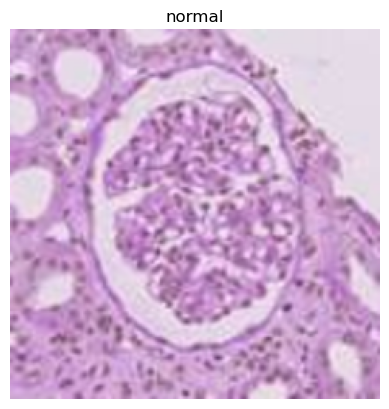

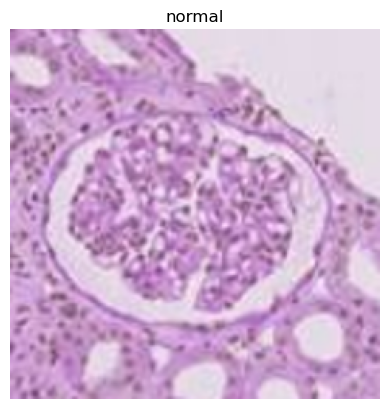

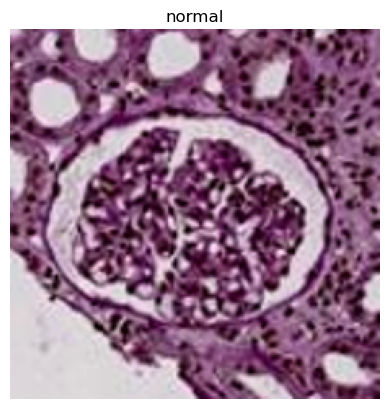

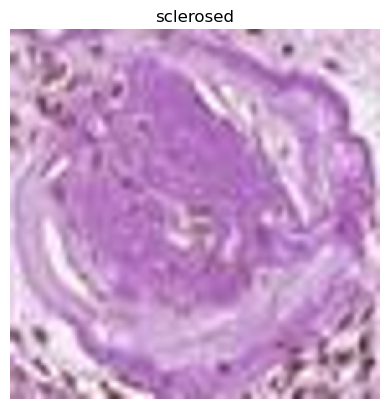

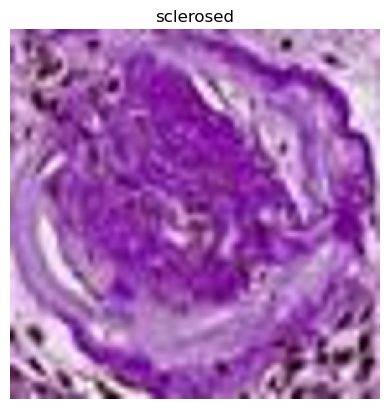

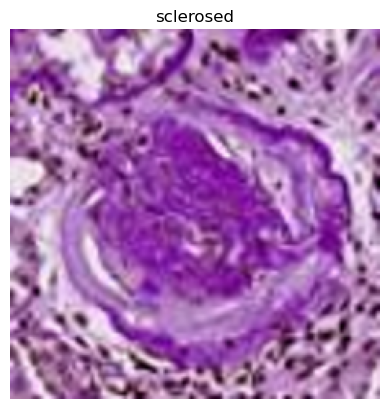

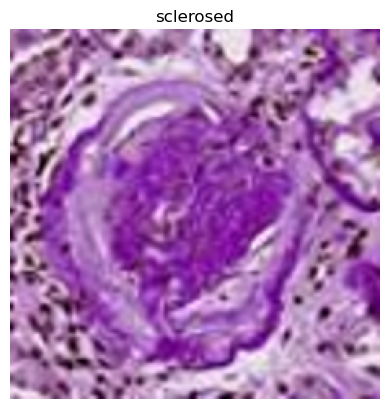

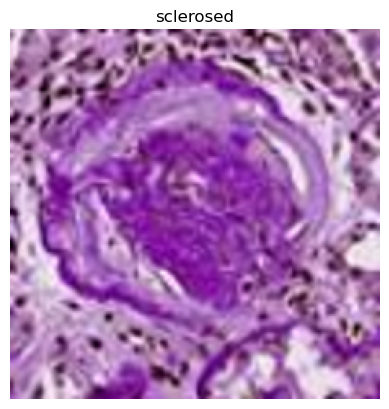

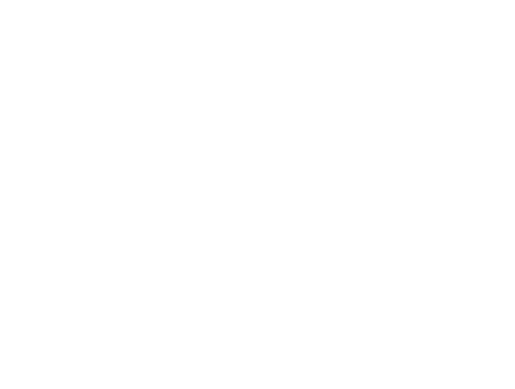

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

DATADIR = r"C:\Users\Sachin\OneDrive\Desktop\delete\biopsy dataset whole dataset/"
CATEGORIES = ["normal", "sclerosed"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    i=0
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path,img))
        plt.imshow(img)
        plt.title(('normal' if category == "normal" else 'sclerosed'))
        plt.show()
        plt.axis("off")
        i+=1
        if i == 5:
            break
        
    

In [34]:
IMG_SIZE = 180 
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [35]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,180,180,1)

(2340, 180, 180)


In [36]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 2)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (1872, 180, 180, 1)
x_test shape (468, 180, 180, 1)
y_train shape (1872, 2)
y_test shape (468, 2)


In [38]:
from keras.layers import Conv2D
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

# Define the PReLU activation function
def prelu_activation(x):
    alpha = 0.25 # You can adjust the initial value of alpha as needed
    return Activation('relu')(x) - alpha * Activation('relu')(-x)

# Register the custom PReLU activation function
get_custom_objects().update({'prelu_activation': Activation(prelu_activation)})

# Use PReLU in your model
# model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
#                  activation = prelu_activation, input_shape = (180,180,1)))


In [40]:
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import PReLU
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation =prelu_activation, input_shape = (180,180,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#
model.add(Conv2D(filters = 64, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# 
model.add(Flatten())
model.add(Dense(96, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation = "softmax"))
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50
batch_size = 40
datagen = ImageDataGenerator(   
        rotation_range=15,
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

In [ ]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

Epoch 1/50
46/46 [==============================] - 40s 850ms/step - loss: 0.8467 - accuracy: 0.5147 - val_loss: 0.6634 - val_accuracy: 0.7350
Epoch 2/50
46/46 [==============================] - 39s 845ms/step - loss: 0.5757 - accuracy: 0.6725 - val_loss: 0.4870 - val_accuracy: 0.7585
Epoch 3/50
46/46 [==============================] - 40s 870ms/step - loss: 0.3445 - accuracy: 0.7893 - val_loss: 0.2762 - val_accuracy: 0.8953
Epoch 4/50
46/46 [==============================] - 56s 1s/step - loss: 0.2565 - accuracy: 0.8592 - val_loss: 0.1645 - val_accuracy: 0.9402
Epoch 5/50
46/46 [==============================] - 41s 872ms/step - loss: 0.2531 - accuracy: 0.9001 - val_loss: 0.1682 - val_accuracy: 0.9487
Epoch 6/50
46/46 [==============================] - 41s 898ms/step - loss: 0.2714 - accuracy: 0.9067 - val_loss: 0.1630 - val_accuracy: 0.9444
Epoch 7/50
46/46 [==============================] - 39s 840ms/step - loss: 0.2638 - accuracy: 0.9088 - val_loss: 0.1391 - val_accuracy: 0.9509
Ep

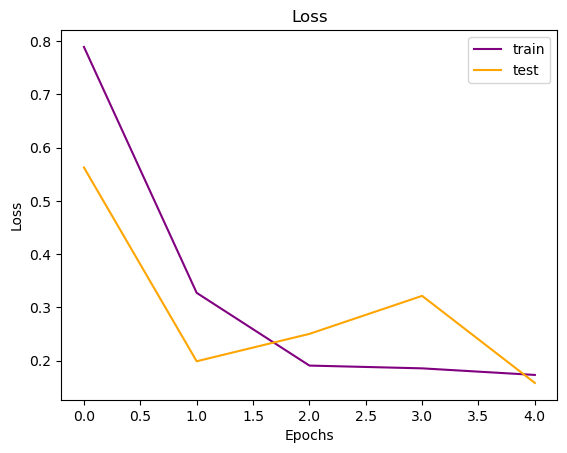

<Figure size 640x480 with 0 Axes>

In [8]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

plt.savefig("loss_graph.png") 

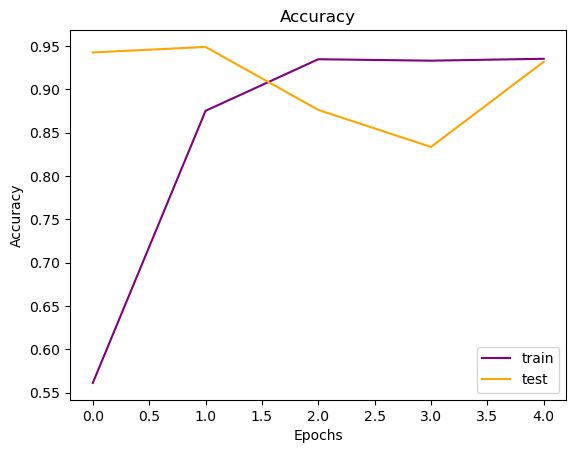

<Figure size 640x480 with 0 Axes>

In [9]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

plt.savefig("accuracy_graph.png") 

In [30]:
# Save the model with .h5 extension
model.save('model.h5')

In [31]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import load_model

# Load the trained model
model = load_model('model.h5')

# # Load the test data
# X_test = ...  # Load your test data here
# y_test = ...  # Load your test labels here

# Perform predictions
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (assuming threshold of 0.5)

# Calculate precision, recall, and F1-score with 'macro' average
precision = precision_score(Y_val, y_pred, average='macro')
recall = recall_score(Y_val, y_pred, average='macro')
f1_score = f1_score(Y_val, y_pred, average='macro')

# Display the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))
print("Support: {}".format(len(Y_val)))


15/15 [==============================] - 3s 199ms/step
Precision: 0.9294
Recall: 0.9287
F1-score: 0.9273
Support: 468


15/15 [==============================] - 2s 158ms/step


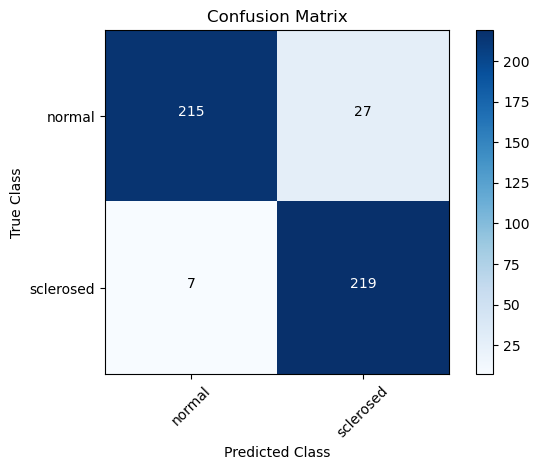

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from keras.models import load_model

# Load the trained model
model = load_model('model.h5')

# # Load the test data
# X_test = ...  # Load your test data here
# y_test = ...  # Load your test labels here

# Perform predictions
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (assuming threshold of 0.5)

# Convert predictions and ground truth labels to binary values (0 or 1)
y_pred = np.argmax(y_pred, axis=1)
Y_val = np.argmax(Y_val, axis=1)

# Create confusion matrix
cm = confusion_matrix(Y_val, y_pred)

# Define class labels (assuming binary classification)
class_labels = ['normal', 'sclerosed']

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add values to the confusion matrix plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


Dataset names in model.h5 file:  ['conv2d', 'conv2d_1', 'conv2d_2', 'dense', 'dense_1', 'dropout', 'dropout_1', 'dropout_2', 'dropout_3', 'flatten', 'max_pooling2d', 'max_pooling2d_1', 'max_pooling2d_2']
